这一 Notebook 的内容参考：Bayesian Optimization in Action

# 2.4 [Implementing Gaussian process in Python](https://github.com/KrisNguyen135/bayesian-optimization-in-action/blob/main/CH02/01%20-%20Gaussian%20processes.ipynb)

### 2.4.1 Setting up the training data

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
def forrester_1d(x):
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

In [4]:
torch.manual_seed(21)
train_x = torch.rand(size=(3, 1)) * 6 - 3  # x 限制在 [-3, 3]
train_y = forrester_1d(train_x)

train_x, train_y

(tensor([[-0.1586],
         [ 0.6816],
         [-2.9276]]),
 tensor([0.8593, 1.1243, 0.5136]))

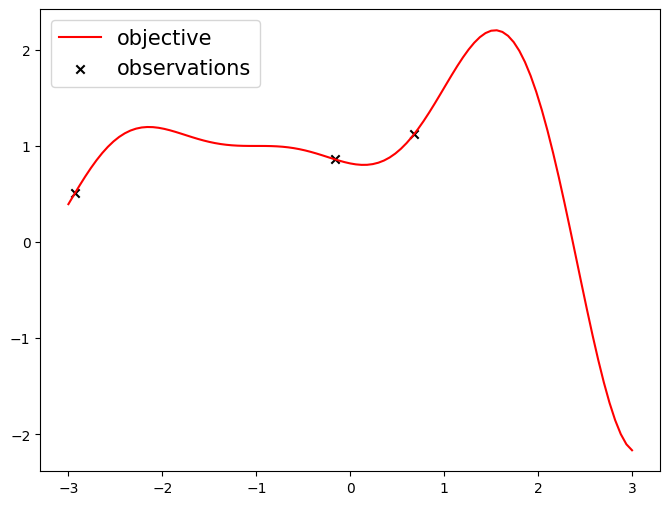

In [8]:
xs = torch.linspace(-3, 3, 101).unsqueeze(1)
ys = forrester_1d(xs)

plt.figure(figsize=(8, 6))
plt.plot(xs, ys, label='objective', color='red')
plt.scatter(train_x, train_y, marker='x', color='k', label='observations')
plt.legend(loc='best', fontsize=15)
plt.show()

### 2.4.2 Implementing a Gaussian process class

In [9]:
import gpytorch


class BaseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()  # 均值函数定义。以先验形式输出零均值预测
        self.covar_module = gpytorch.kernels.RBFKernel()  # 协方差函数定义。径向基函数内核--RBF kernel

    def forward(self, x):
        # 不是按顺序将结果传递给不同的模块，而是同时将输入传递给均值函数和协方差函数。
        # The output of these modules is then combined to create an MVN distribution.

        # 由于我们有一个均值函数和一个协方差函数，我们只需在输入 x 上调用它们来计算均值和协方差预测。
        # 最后，我们需要返回的是一个 MVN 分布

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

使用 GP 的优点之一是，即使没有任何数据，我们仍然可以利用先验均值函数中包含的知识进行预测。

## 2.4.3 Making predictions with a GP

In [22]:
# declare the GP
lengthscale = 1  # 长度尺度 
noise = 1e-4  # 噪声方差

likelihood = gpytorch.likelihoods.GaussianLikelihood()
# 为了在没有任何训练数据的情况下初始化 GP 对象，我们将 None 作为训练特征 (train_x) 和标签 (train_y) 传递。
model = BaseGPModel(None, None, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

## 2.4.4 Visualizing predictions by a Gaussian process

In [23]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))  # 这里似然函数将噪声纳入GP
    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()  # 95% CI

    torch.manual_seed(21)
    samples = predictive_distribution.sample(torch.Size([5]))  # 采样 5 次

In [24]:
predictive_upper

tensor([2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001, 2.0001,
        2.0001, 2.0001])

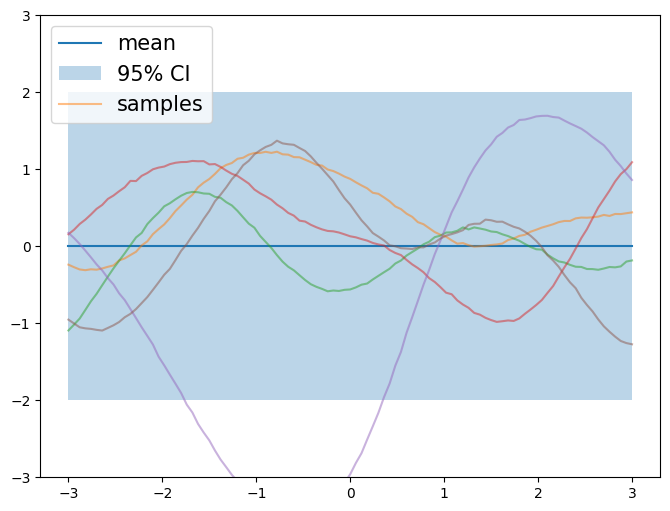

In [25]:
plt.figure(figsize=(8, 6))

plt.plot(xs, predictive_mean.detach(), label="mean")
plt.fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
)

plt.plot(xs, samples[0, :], alpha=0.5, label="samples")

for i in range(1, samples.shape[0]):
    plt.plot(xs, samples[i, :], alpha=0.5)

plt.ylim(-3, 3)

plt.legend(fontsize=15)
plt.show()

我们之前的 GP 产生的均值函数恒定为零，并且我们的 95% CI 是恒定的。这是可以预料的。

均值和置信区间只是对期望的测量：它们表示我们对可能发生的情况的许多不同实现的预测的平均行为。然而，当我们绘制单个样本时，我们发现每个样本都有一个非常复杂的形状，而且根本不是恒定的。所有这一切都表明，虽然我们在任何点的预测的预期值都为零，但它可以取的值范围很广。这表明 GP 可以以灵活的方式对复杂的非线性行为进行建模

In [26]:
# 接下来用训练数据初始化 model
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [27]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()

    torch.manual_seed(21)
    samples = predictive_distribution.sample(torch.Size([5]))

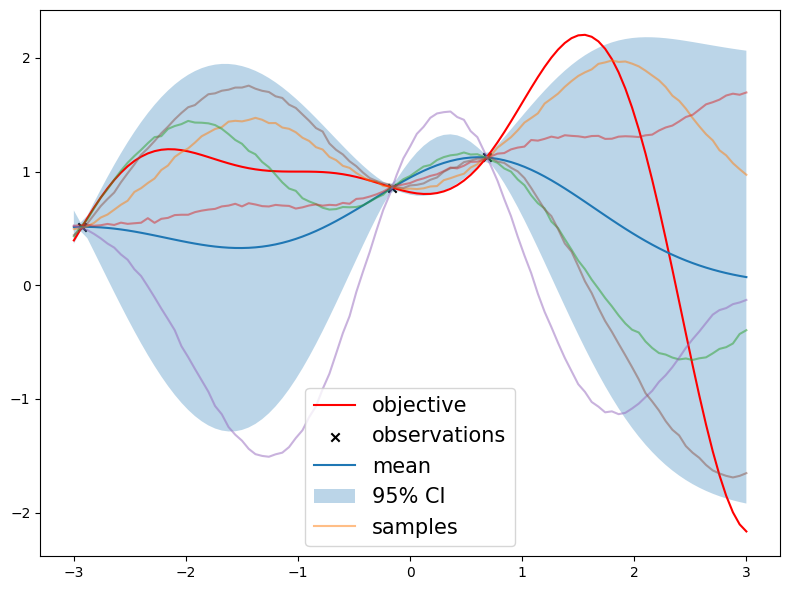

In [29]:
plt.figure(figsize=(8, 6))

plt.plot(xs, ys, label="objective", c="r")
plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

plt.plot(xs, predictive_mean, label="mean")
plt.fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
)

plt.plot(xs, samples[0, :], alpha=0.5, label="samples")

for i in range(1, samples.shape[0]):
    plt.plot(xs, samples[i, :], alpha=0.5)

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

## 2.4.5 Going beyond one-dimensional objective functions

In [30]:
# 创建二维数据
train_x = torch.tensor([[0.0, 0.0], [1.0, 2.0], [-1.0, 1.0]])

train_y = torch.tensor([0.0, -1.0, 0.5])

In [31]:
grid_x = torch.linspace(-3, 3, 101)  # 1d

grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x, indexing="ij")  # 2d
xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten()]).transpose(-1, -2)

In [32]:
xs

tensor([[-3.0000, -3.0000],
        [-3.0000, -2.9400],
        [-3.0000, -2.8800],
        ...,
        [ 3.0000,  2.8800],
        [ 3.0000,  2.9400],
        [ 3.0000,  3.0000]])

In [33]:
# declare the GP
lengthscale = 1
noise = 1e-4

# 不需要修改 BaseGPModel 类或任何预测代码
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

绘制预测平均值的热图和预测标准差的另一热图。虽然标准差并不完全是 95% CI，但这两个对象本质上确实量化了同一件事：我们对函数值的不确定性。

In [35]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_stddev = predictive_distribution.stddev  # 提取标准差

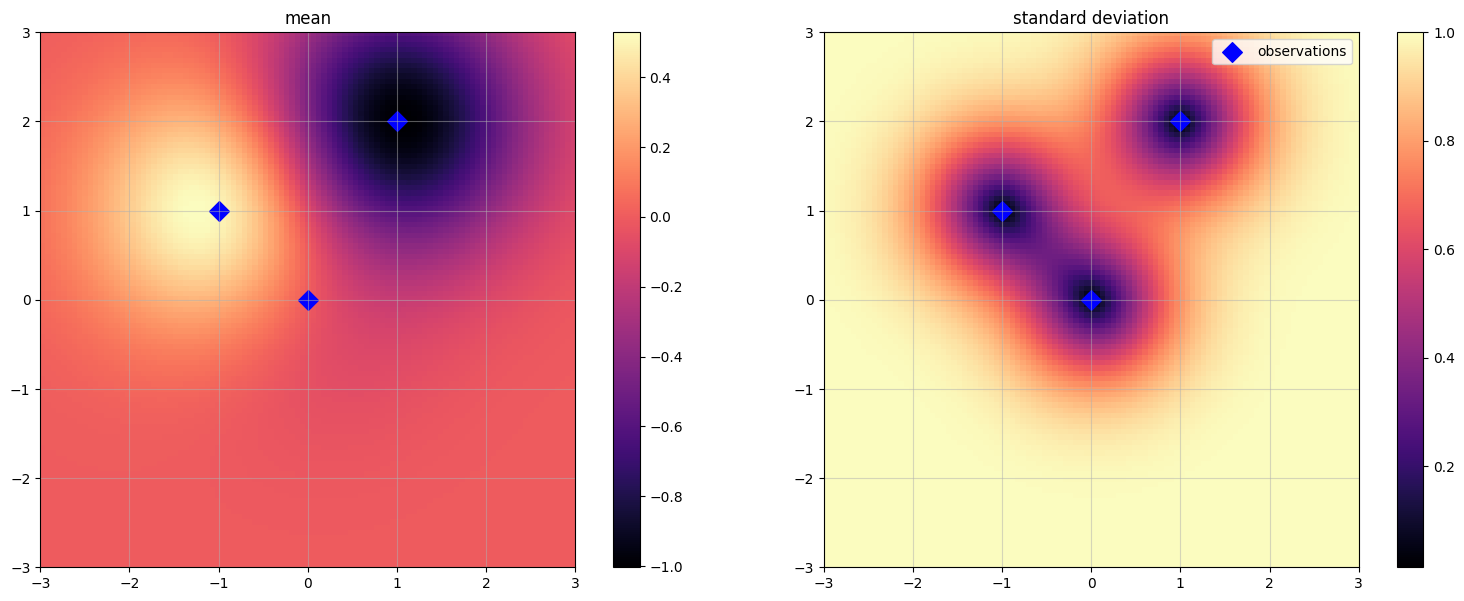

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# The first heat map for the predictive mean
c = ax[0].imshow(
    predictive_mean.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[-3, 3, -3, 3],
    cmap="magma"
)
plt.colorbar(c, ax=ax[0])
ax[0].scatter(train_x[:, 0], train_x[:, 1], c="blue", marker="D", s=100)
ax[0].set_title("mean")
ax[0].grid(alpha=0.5)

# The second heat map for the predictive standard deviation
c = ax[1].imshow(
    predictive_stddev.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[-3, 3, -3, 3],
    cmap="magma"
)
plt.colorbar(c, ax=ax[1])
ax[1].scatter(
    train_x[:, 0], train_x[:, 1], c="blue", marker="D", s=100, label="observations"
)
ax[1].set_title("standard deviation")
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

我们看到一维情况下的情况也扩展到了这个例子：
- 左侧面板显示我们的平均预测与我们的训练数据一致：左侧的明亮斑点对应于 (–1, 1)，它有值为 0.5，而右侧的深色斑点对应于 (1, 2)，其值为 –1（我们在 (0, 0) 处的观察值为 0，这也是先验平均值，因此它不像其他两个那样在左侧面板中明显指出）。
- 我们的不确定性（通过预测标准差来衡量）在训练数据中的三个点周围接近于零，如右图所示。远离这些数据点，标准差平滑地增加至归一化最大不确定性 1.
- 这意味着当我们进入更高维度时，GP 的所有优良特性（例如平滑插值和不确定性量化）都会被保留。

## 2.5 [Exercise](https://github.com/KrisNguyen135/bayesian-optimization-in-action/blob/main/CH02/02%20-%20Exercise.ipynb)

Steps:
1. 创建表 2.2 中包含的四维数据集
2. 通过从所有值中减去平均值并将结果除以标准差来标准化第五列
3. 将前四列视为特征，将第五列视为标签。根据这些数据训练GP。可以重用在本章中实现的 GP 模型类
4. 创建包含百分比为零的锗和锰的成分的测试数据集。换句话说，测试集是单位正方形上的网格，其轴是铅和锡的百分比。

In [1]:
import torch
import matplotlib.pyplot as plt

### 1. Create the training dataset

In [2]:
train_x = torch.tensor([
    [1 / 2, 1 / 2, 0, 0],
    [1 / 3, 1 / 3, 1 / 3, 0],
    [0, 1 / 2, 1 / 2, 0],
    [0, 1 / 3, 1 / 3, 1 / 3]
])

train_y = torch.tensor([192.08, 258.30, 187.24, 188.54])

### 2. Normalize the labels

In [3]:
train_y = (train_y - train_y.mean()) / train_y.std()
train_y

tensor([-0.4183,  1.4974, -0.5583, -0.5207])

### 3. Train a GP

In [4]:
import gpytorch


class BaseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### 4. Create the test data

In [6]:
grid_x = torch.linspace(0, 1, 101)

grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x, indexing='ij')
xs = torch.vstack([
    grid_x1.flatten(),  # 1st column
    grid_x2.flatten(),  # 2nd column
    torch.zeros(101 ** 2),
    torch.zeros(101 ** 2)
]).transpose(-1, -2)

xs

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0100, 0.0000, 0.0000],
        [0.0000, 0.0200, 0.0000, 0.0000],
        ...,
        [1.0000, 0.9800, 0.0000, 0.0000],
        [1.0000, 0.9900, 0.0000, 0.0000],
        [1.0000, 1.0000, 0.0000, 0.0000]])

### 5. Make predictions

In [7]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_stddev = predictive_distribution.stddev

### 6. Visualize the predictions

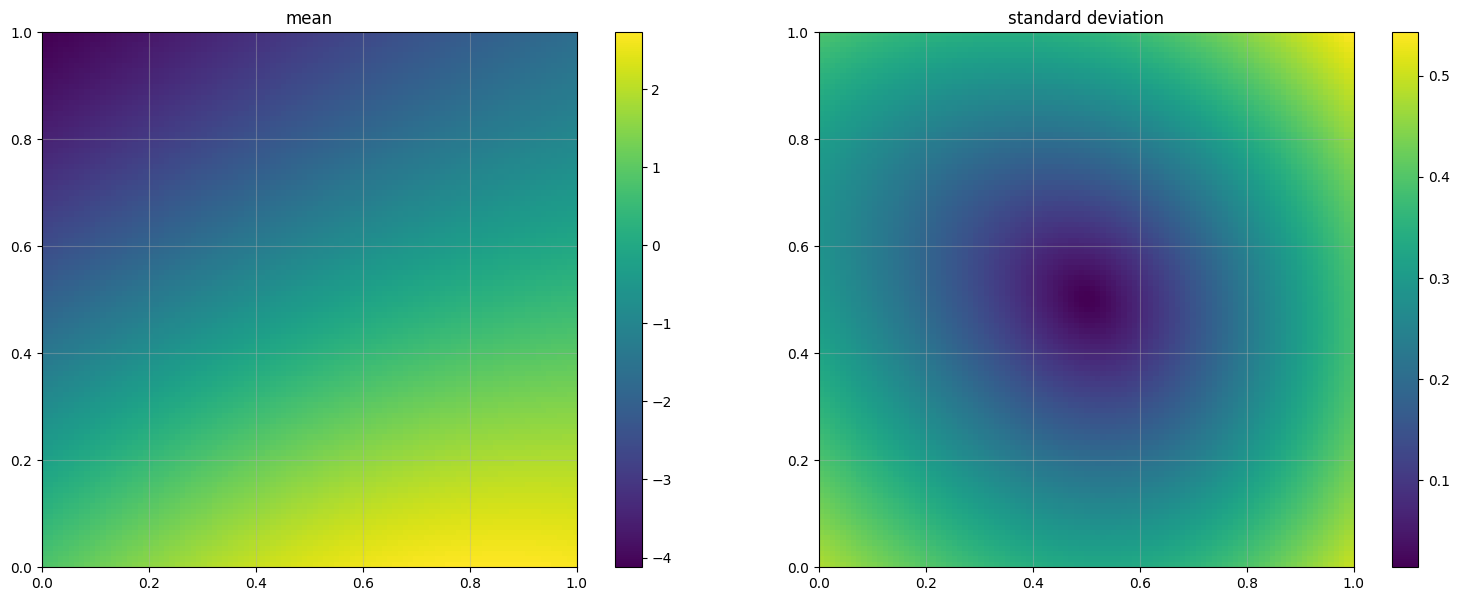

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

c = ax[0].imshow(
    predictive_mean.detach().reshape(101, 101).transpose(-1, -2),
    origin='lower',
    extent=[0, 1, 0, 1]
)
plt.colorbar(c, ax=ax[0])
ax[0].set_title('mean')
ax[0].grid(alpha=0.4)

c = ax[1].imshow(
    predictive_stddev.detach().reshape(101, 101).transpose(-1, -2),
    origin='lower',
    extent=[0, 1, 0, 1]
)
plt.colorbar(c, ax=ax[1])
ax[1].set_title('standard deviation')
ax[1].grid(alpha=0.4)

plt.tight_layout()
plt.show()

# 3.3 [Defining the functional behavior of the mean function](https://github.com/KrisNguyen135/bayesian-optimization-in-action/blob/main/CH03/01%20-%20Mean%20functions.ipynb)

In [83]:
import torch
import gpytorch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [9]:
xs = torch.linspace(0, 10, 101).unsqueeze(1)

train_x = torch.tensor([[0.5], [1.0], [1.5], [3], [4]])
train_y = torch.tensor([0.0625, 0.25, 0.375, 2.25, 4])

In [10]:
# 可视化辅助函数
def visualize_gp_belief(model, likelihood):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_lower, predictive_upper = predictive_distribution.confidence_region()

    plt.figure(figsize=(8, 6))

    plt.scatter(train_x, train_y, marker='x', s=50, c='k', label='observations')
    plt.plot(xs, predictive_mean, label='mean')
    plt.fill_between(xs.flatten(), predictive_lower, predictive_upper, alpha=0.3, label='95% CI')
    plt.legend(fontsize=15)

    plt.tight_layout()
    plt.show()

## 3.3.1 Using the zero mean function as the base strategy

均值的最简单形式是零处的常数函数。在没有数据的情况下，该函数将产生零作为其默认预测。当没有关于目标函数的额外信息（我们可以将其作为先验知识纳入 GP 中）时，使用零均值函数。

具有零均值函数的 GP 的实现如下：

In [5]:
class ConstantMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ConstantMeanGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Attention: 这里使用常数均值来初始化 mean function，虽然默认为常数 0，但允许调整来产生更好的模型
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

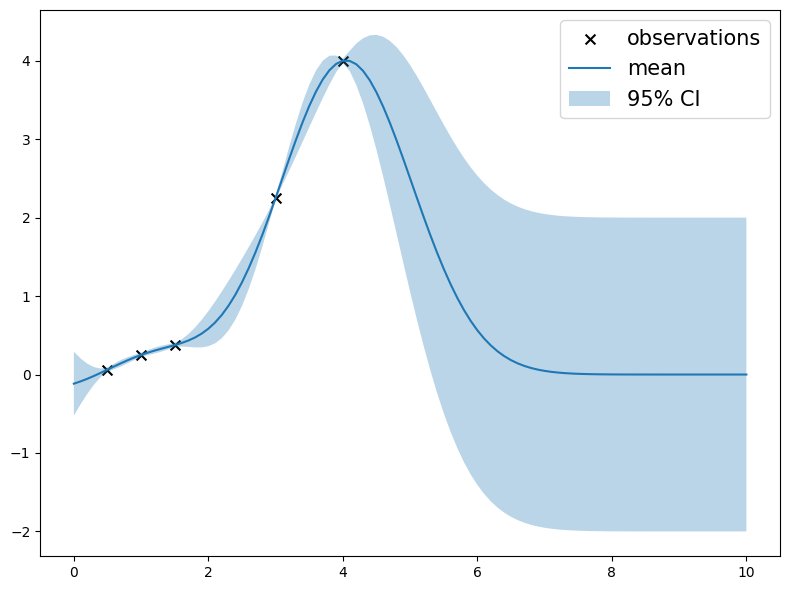

In [6]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ConstantMeanGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

- 后验均值函数平滑地插值作为我们训练数据点的 xs
- 95% CI 在这些数据点周围消失，表明不确定性的量化经过良好校准
- 
一旦我们远离训练数据点（图的右侧），我们的后验均值函数就会恢复到先前的均值，即零。事实上，这是 GP 的一个重要特征：在没有数据的情况下（在没有观测的区域中），先验均值函数是推理过程的主要驱动力。这具有直观意义，因为在没有实际观察的情况下，预测模型可以做的最好的事情就是利用其均值函数中编码的先验知识。

**IMPORTANT:** 在缺乏数据的情况下，驱动预测的唯一因素就是先验 GP。

## 3.3.2 Using the constant function with gradient descent

在许多情况下，不可能知道目标函数的平均值是多少。那么，我们应该如何为我们的均值函数找到合适的值呢？

我们使用的策略是吸引特定的数量：**给定我们的均值函数的值，训练数据集的可能性有多大。粗略地说，这个数量衡量了我们的模型解释其训练数据的程度。**

如果给定某个值 $c_1$ 的训练数据的可能性高于给定另一个值 $c_2$ 的训练数据的 likelihood，那么我们更喜欢使用 $c_1$ 而不是 $c_2$。
这量化了我们之前关于使用非零均值函数来建模正函数的直觉：值为正的常数均值函数比值为零（或负）的函数更好地解释了完全正函数的观察结果。

GPyTorch 提供了一个方便的类 gpytorch.mlls.ExactMarginalLogLikelihood，它接受 GP 模型并在给定模型的超参数的情况下计算其训练数据的 **边际对数似然 (margin log likelihood)**。

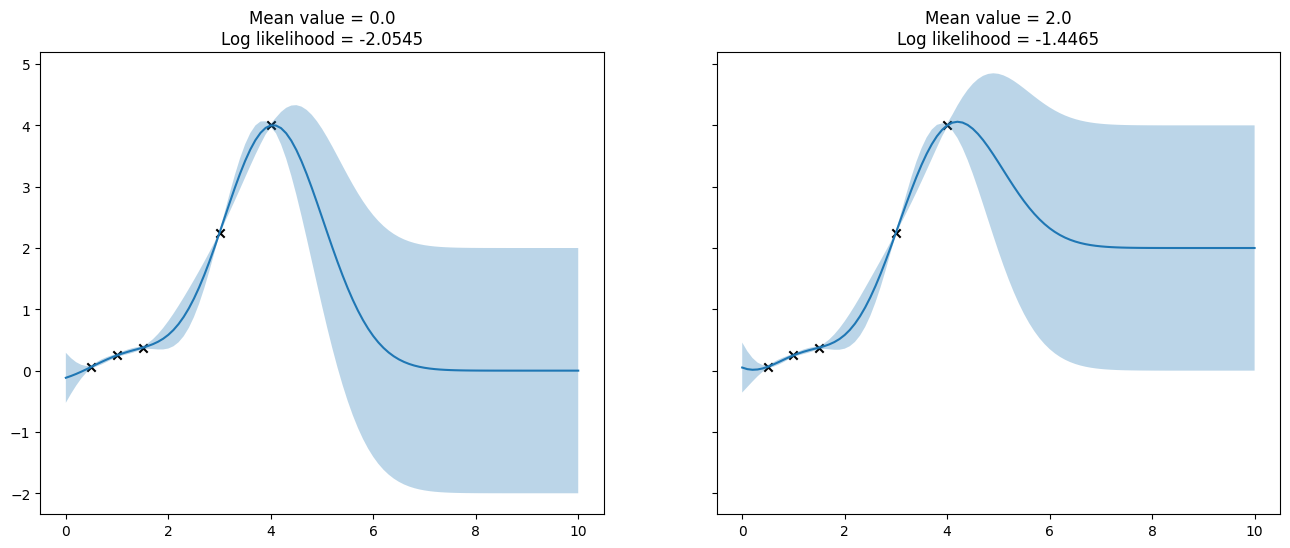

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# first panel
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_upper, predictive_lower = predictive_distribution.confidence_region()

ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

ax[0].plot(xs, predictive_mean, label="mean")
ax[0].fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95\% CI"
)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

with torch.no_grad():
    loss = -mll(model(train_x), train_y)

model.eval()
likelihood.eval()

ax[0].set_title(
    f"Mean value = {model.mean_module.constant.item():.1f}"
    + f"\nLog likelihood = {-loss.item():.4f}"
)

# second panel
model.mean_module.constant = 2  # torch.nn.Parameter(torch.tensor(2.0))

with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_upper, predictive_lower = predictive_distribution.confidence_region()

ax[1].scatter(train_x, train_y, marker="x", c="k", label="observations")

ax[1].plot(xs, predictive_mean, label="mean")
ax[1].fill_between(
    xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95\% CI"
)

model.train()
likelihood.train()

with torch.no_grad():
    loss = -mll(model(train_x), train_y)

model.eval()
likelihood.eval()

ax[1].set_title(
    f"Mean value = {model.mean_module.constant.item():.1f}"
    + f"\nLog likelihood = {-loss.item():.4f}"
)

# plt.tight_layout()
plt.show()

右边是带有值为 2 的均值函数的 GP。请注意，在第二个面板中，图右侧的均值函数恢复为 2，而不是 0。

在这里，第二个 GP 比第一个 GP 具有更高的（对数）可能性，这意味着值 2 比值 0 更好地解释了我们的训练数据。

有了对数似然计算，我们的最后一步就是简单地找到均值函数的值，以使对数似然最大化。换句话说，我们的目标是寻求最能解释我们的训练数据的平均值。由于我们可以使用对数似然计算，因此可以使用基于梯度的优化算法（例如梯度下降）来迭代地细化我们拥有的平均值。收敛后，我们将得到一个良好的平均值，从而提供高数据可能性。

In [8]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ConstantMeanGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

In [11]:
# train the hyperparameter (the constant)

# 定义优化器
optimizer = torch.optim.Adam([model.mean_module.constant], lr=0.01)
# 定义对数似然
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
constants = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = - mll(output, train_y)  # negative marginal log likelihood

    loss.backward()

    losses.append(loss.item())
    constants.append(model.mean_module.constant.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

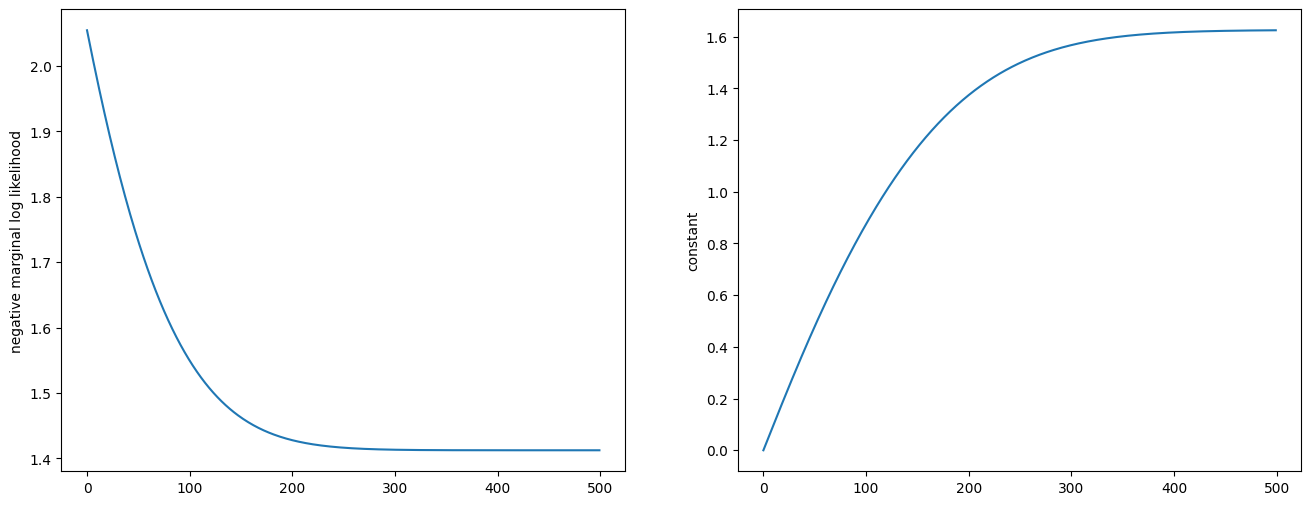

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(constants)
ax[1].set_ylabel("constant")

plt.show()

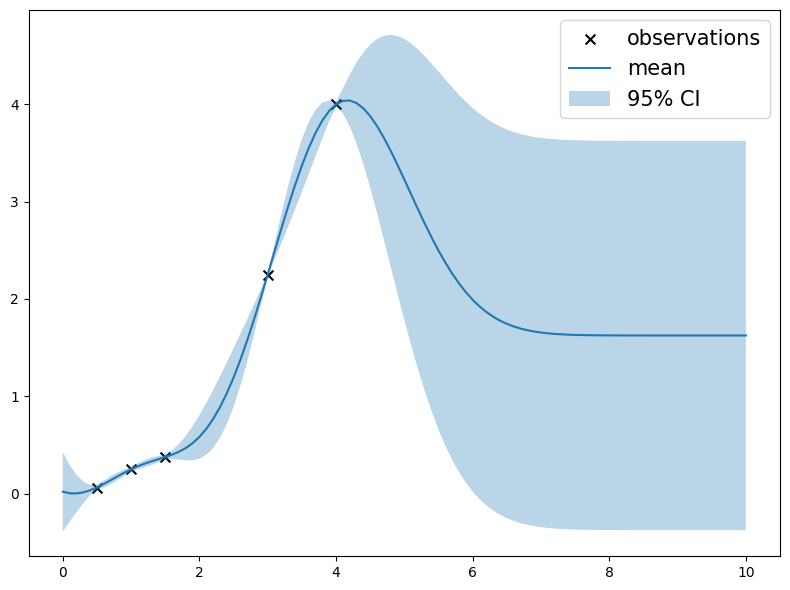

In [13]:
visualize_gp_belief(model, likelihood)

## 3.3.3 Using the linear function with gradient descent

在恒定均值函数下，权重向量 w 固定为零向量，偏差 b 是我们在上一小节中学习优化的平均值。换句话说，线性函数是比常均值函数更通用的模型。

In [18]:
class LinearMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.LinearMean(1)
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = LinearMeanGPModel(train_x, train_y, likelihood)

model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

In [20]:
# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.mean_module.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
weights = []
biases = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    weights.append(model.mean_module.weights.item())
    biases.append(model.mean_module.bias.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

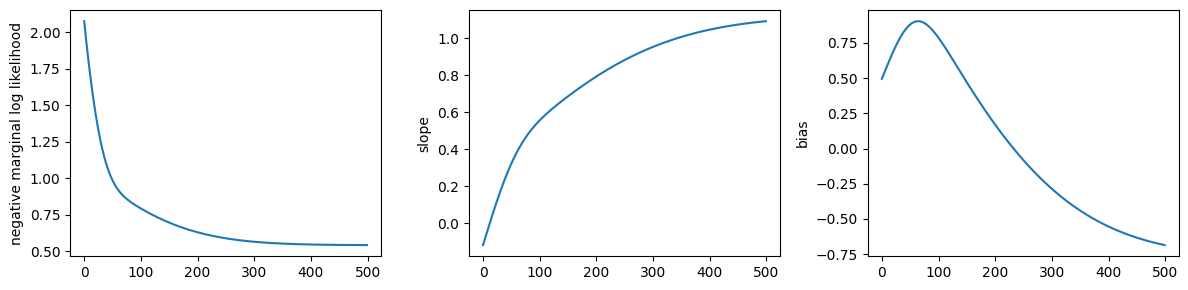

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(weights)
ax[1].set_ylabel("slope")

ax[2].plot(biases)
ax[2].set_ylabel("bias")

plt.tight_layout()
plt.show()

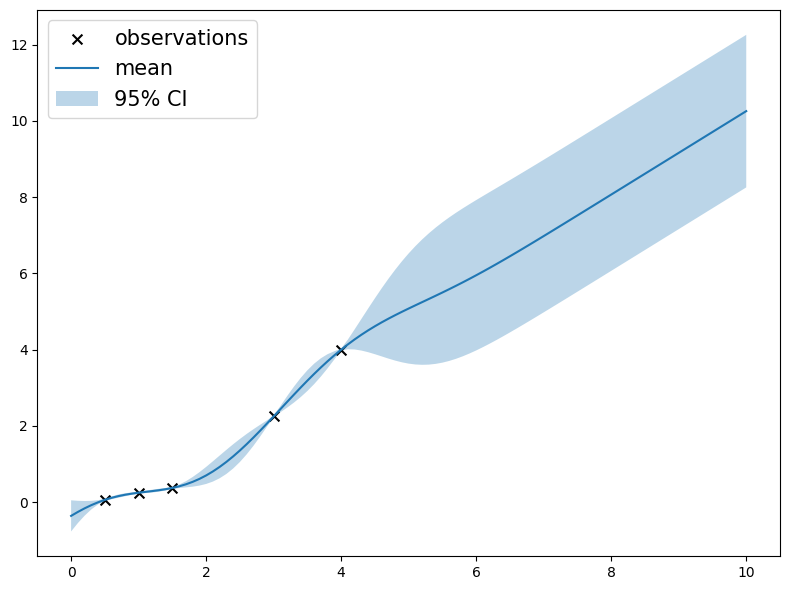

In [28]:
visualize_gp_belief(model, likelihood)

使用的线性均值函数驱动整个 GP 模型呈现上升趋势。这是因为我们的训练数据中的五个数据点的最佳拟合线是具有正斜率的线

## 3.3.4 Using the quadratic function by implementing a custom mean function (二次函数)

自定义均值函数类：
继承 gpytorch.means.Mean，该类是所有 GPyTorch 均值函数实现的基础。为了实现我们的自定义逻辑，我们需要重写两个方法：__init__()和forward()，这和我们实现GP模型时一模一样！在 __init__() 中，我们需要声明我们的平均值函数包含哪些参数。这个过程称为参数注册。

线性函数有两个参数：斜率和截距，而二次函数有三个参数： 二阶项 x2 的系数；一阶项 x 的系数；以及零阶项的系数，通常称为偏差。

In [29]:
# 定义二次函数的均值函数
class QuadraticMean(gpytorch.means.Mean):
    def __init__(self, batch_shape=torch.Size(), bias=True):
        super().__init__()
        self.register_parameter(
            name='second', parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1, 1))  # 二阶系数
        )
        self.register_parameter(
            name='first', parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1, 1))  # 一阶系数
        )

        if bias:
            self.register_parameter(
                name='bias', parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1))
            )
        else:
            self.bias = None

    def forward(self, x):
        res = x.pow(2).matmul(self.second).squeeze(-1) + x.matmul(self.first).squeeze(-1)
        if self.bias is not None:
            res = res + self.bias

        return res


# 定义 GP
class QuadraticMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = QuadraticMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [43]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = QuadraticMeanGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

In [44]:
# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.mean_module.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
firsts = []
seconds = []
biases = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    firsts.append(model.mean_module.first.item())
    seconds.append(model.mean_module.second.item())
    biases.append(model.mean_module.bias.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

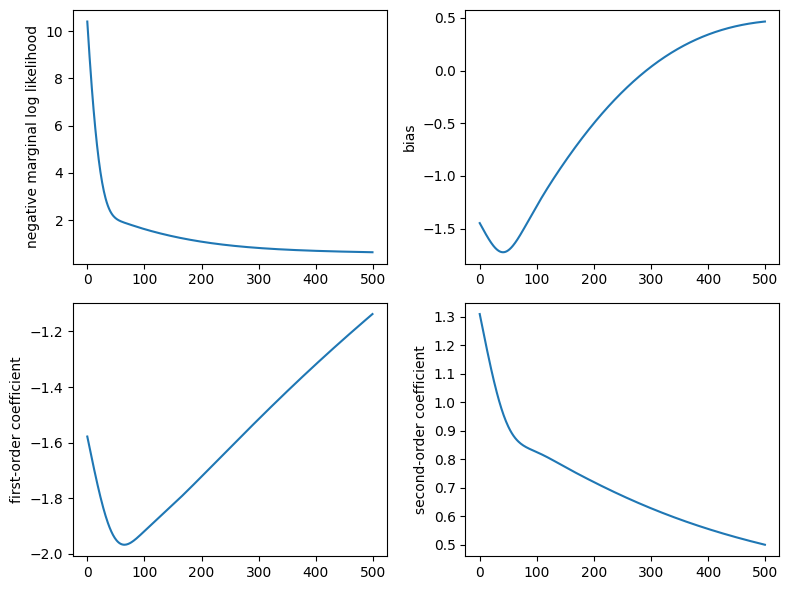

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0][0].plot(losses)
ax[0][0].set_ylabel("negative marginal log likelihood")

ax[0][1].plot(biases)
ax[0][1].set_ylabel("bias")

ax[1][0].plot(firsts)
ax[1][0].set_ylabel("first-order coefficient")

ax[1][1].plot(seconds)
ax[1][1].set_ylabel("second-order coefficient")

plt.tight_layout()
plt.show()

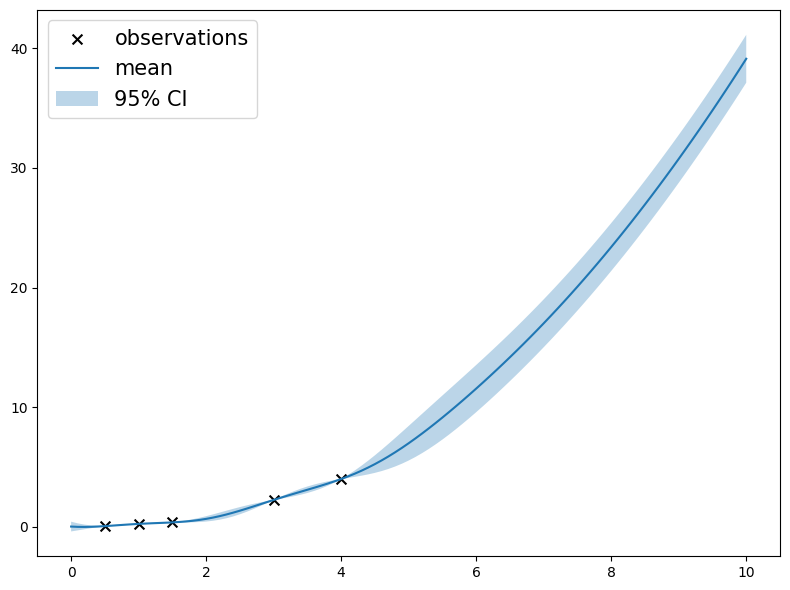

In [46]:
visualize_gp_belief(model, likelihood)

# 3.4 Defining variability and smoothness with the covariance function

In [47]:
import torch
import gpytorch

from math import pi

import matplotlib.pyplot as plt
# plt.style.use("bmh")
# plt.rcParams["image.cmap"] = "Blues_r"

from tqdm.notebook import tqdm

In [48]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)


def visualize_gp_belief(model, likelihood, num_samples=5):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

    plt.figure(figsize=(8, 6))

    plt.plot(xs, ys, label="objective", c="r")
    plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

    plt.plot(xs, predictive_mean, label="mean")
    plt.fill_between(
        xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
    )

    torch.manual_seed(0)
    for i in range(num_samples):
        plt.plot(xs, predictive_distribution.sample(), alpha=0.5, linewidth=2)

    plt.legend(fontsize=15)
    plt.show()

In [49]:
xs = torch.linspace(-3, 3, 101).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(0)
train_x = torch.rand(size=(3, 1)) * 6 - 3
train_y = forrester_1d(train_x)

## 3.4.1 Setting the scales of the covariance function

通过协方差函数控制 GP 行为的第一种方法是设置长度尺度和输出尺度。这些尺度，就像均值函数中的常数或系数一样，是协方差函数的超参数：
- 长度尺度控制 GP 输入的尺度，从而控制 GP 沿轴变化的速度，即，我们认为目标函数随输入维度变化的程度
- 输出尺度定义了 GP 输出的范围，或者换句话说，就是其预测的范围。

In [50]:
class ScaleGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())  # 实现了输出缩放，即按某个常数因子缩放 RBF 内核的输出

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

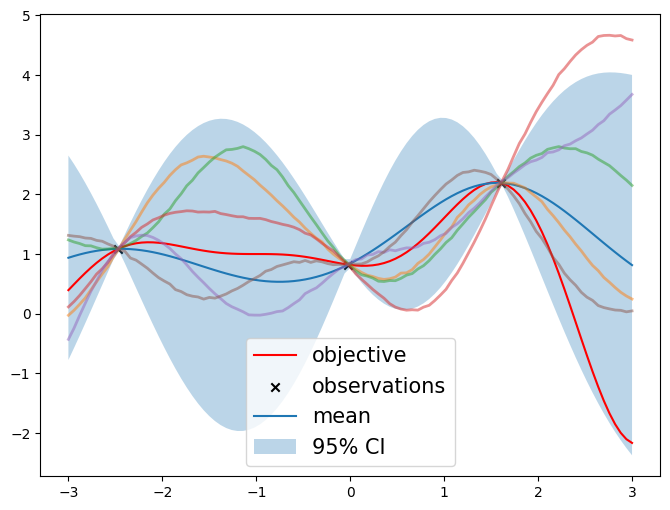

In [51]:
# declare the GP
lengthscale = 1  # 0.3, 1, 3
outputscale = 3  # 0.3, 1, 3
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ScaleGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.base_kernel.lengthscale = lengthscale
model.covar_module.outputscale = outputscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

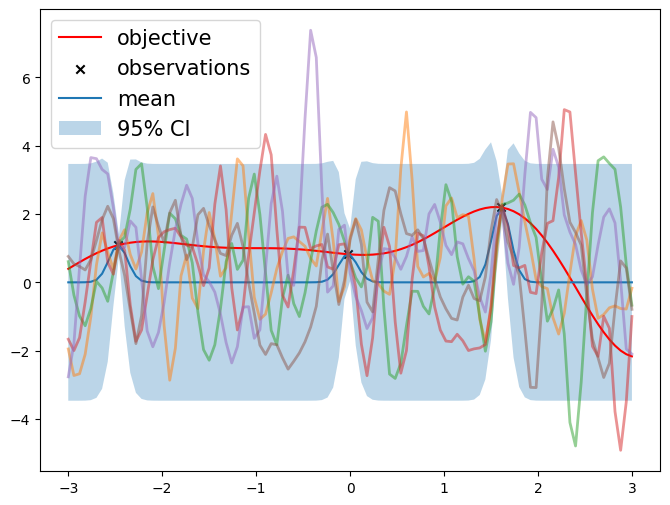

In [61]:
# declare the GP
lengthscale = 0.1  # 0.3, 1, 3
outputscale = 3  # 0.3, 1, 3
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ScaleGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.base_kernel.lengthscale = lengthscale
model.covar_module.outputscale = outputscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

In [52]:
# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.covar_module.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
lengthscales = []
outputscales = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    lengthscales.append(model.covar_module.base_kernel.lengthscale.item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

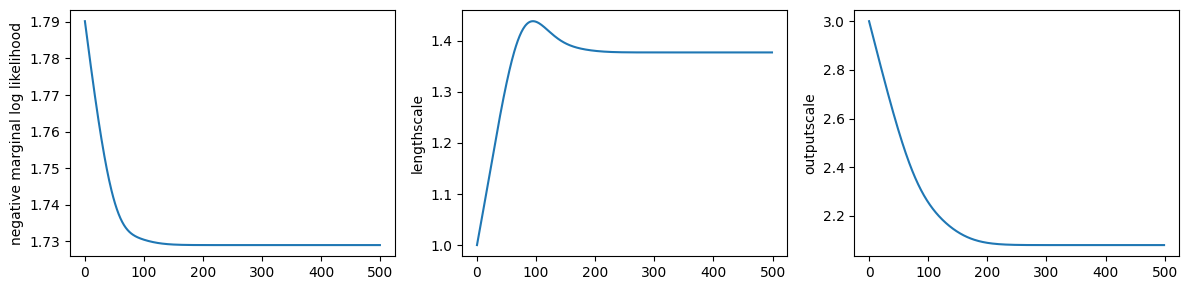

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(lengthscales)
ax[1].set_ylabel("lengthscale")

ax[2].plot(outputscales)
ax[2].set_ylabel("outputscale")

plt.tight_layout()
plt.show()

In [55]:
(
    model.covar_module.base_kernel.lengthscale.item(),
    model.covar_module.outputscale.item(),
)

(1.3772369623184204, 2.079803705215454)

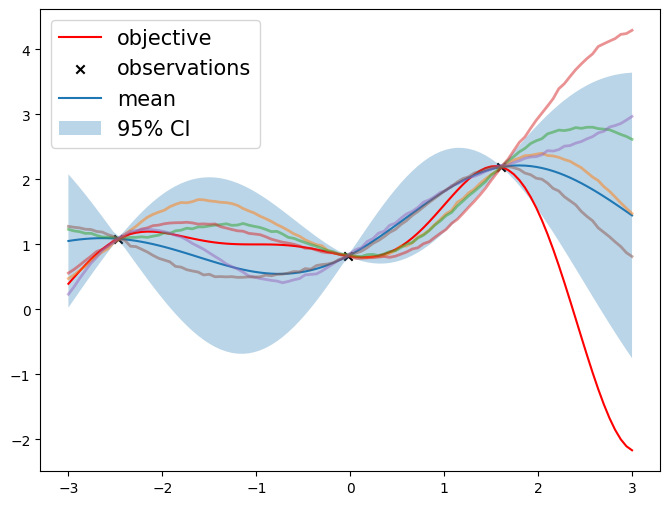

In [56]:
visualize_gp_belief(model, likelihood)

## 3.4.2 Controlling smoothness with different covariance functions

In [62]:
class RBFGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

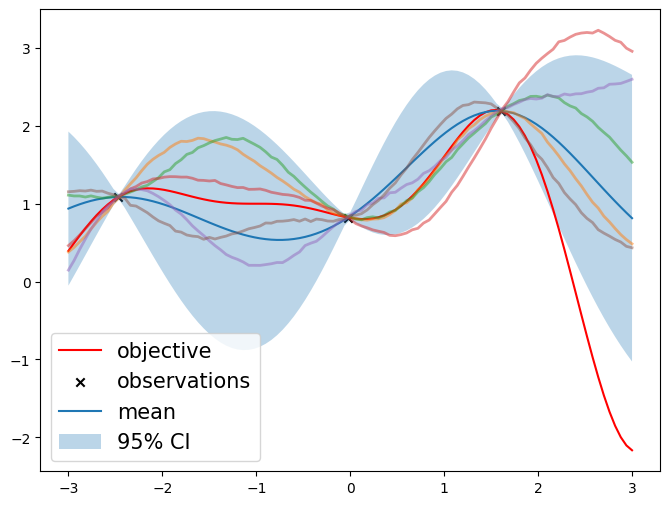

In [63]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RBFGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

In [64]:
class MaternGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, nu):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

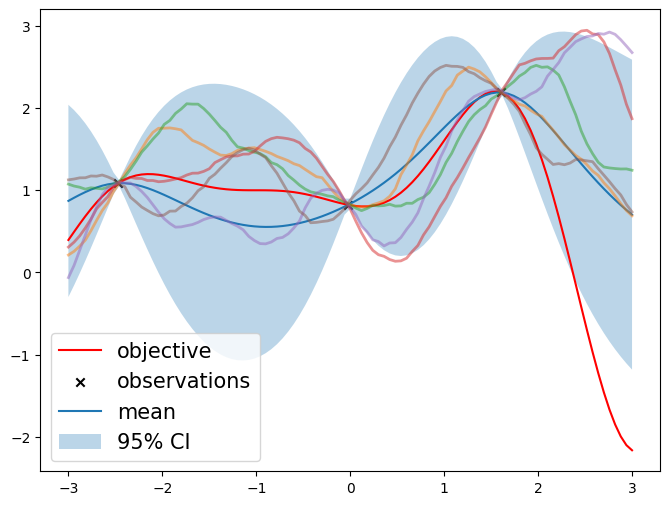

In [65]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MaternGPModel(train_x, train_y, likelihood, 2.5)  # nu = 2.5, 控制平滑度
# GPyTorch 支持 nu 的三个值：1/2、3/2 和 5/2，分别对应于不可微分、一次可微分和两次可微分的函数。换句话说，这个nu参数越大，我们的GP就越平滑。
# Matérn 5/2 内核通常是首选

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

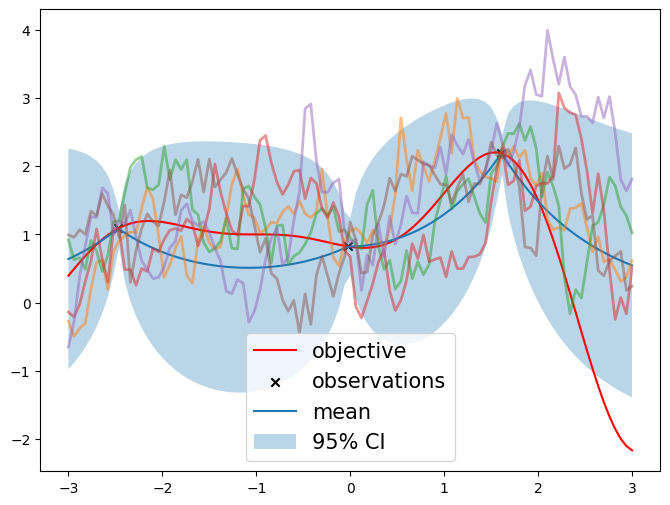

In [67]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MaternGPModel(train_x, train_y, likelihood, 0.5)  # nu = 0.5

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

visualize_gp_belief(model, likelihood)

## 3.4.3 Modeling different levels of variability with multiple length scales (多长度尺度)

由于我们只考虑一维目标函数（输入具有一个特征的函数），因此我们只需要考虑一个长度尺度。

然而，我们可以想象这样的场景：高维目标函数（其输入具有多个特征）在某些维度上具有更大的可变性，而在其他维度上则更平滑。也就是说，一些维度具有小长度尺度，而另一些维度具有大长度尺度。请记住本章开头的激励人心的例子：与额外平方英尺的居住面积相比，额外楼层的房屋价格预测会增加更大的幅度。在本小节中，我们将探讨如何在 GP 中维护多个长度尺度来对这些函数进行建模。

我们使用一个名为 Ackley 的具体二维目标函数，它可以被修改为在不同维度上具有不同程度的可变性。我们实现该功能如下：

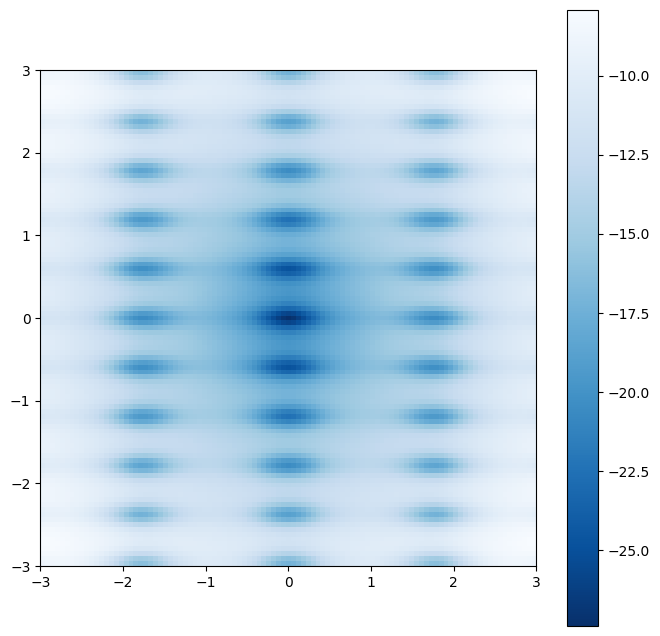

In [71]:
def ackley(x):
    # a modification of https://www.sfu.ca/~ssurjano/ackley.html
    return -20 * torch.exp(
        -0.2 * torch.sqrt((x[:, 0] ** 2 + x[:, 1] ** 2) / 2)
    ) - torch.exp(torch.cos(2 * pi * x[:, 0] / 3) + torch.cos(2 * pi * x[:, 1]))


xs = torch.linspace(-5, 5, 101)
x1, x2 = torch.meshgrid(xs, xs, indexing="ij")
xs = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = ackley(xs)

plt.figure(figsize=(8, 8))

plt.imshow(ys.reshape(101, 101).T, origin="lower", extent=[-3, 3, -3, 3], cmap='Blues_r')
plt.colorbar()
plt.show()

**IMPORTANT:** 使用每个维度都有长度尺度的内核称为自动相关性确定 (ARD)。该术语表示在使用梯度下降优化这些长度尺度后，我们可以推断目标函数的每个维度与函数值的相关程度。具有大长度尺度的维度具有较低的可变性，因此与具有小长度尺度的维度相比，在建模目标函数值时相关性较低

In [72]:
torch.manual_seed(21)
train_x = torch.rand(size=(100, 2)) * 6 - 3
train_y = ackley(train_x)

In [73]:
class ARDGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)  # 将 ard_num_dims 参数指定为等于初始化协方差函数时目标函数的维数
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [74]:
# declare the GP
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ARDGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.likelihood.noise = noise

# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
x_lengthscales = []
y_lengthscales = []
outputscales = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    x_lengthscales.append(model.covar_module.base_kernel.lengthscale[0, 0].item())
    y_lengthscales.append(model.covar_module.base_kernel.lengthscale[0, 1].item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

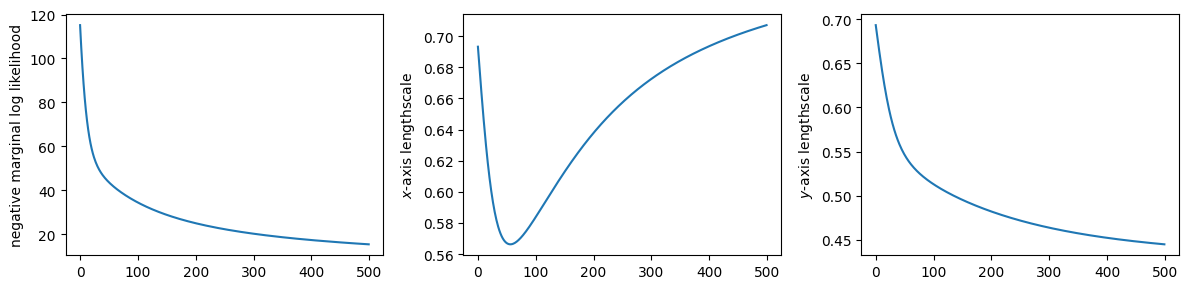

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(x_lengthscales)
ax[1].set_ylabel(r"$x$-axis lengthscale")

ax[2].plot(y_lengthscales)
ax[2].set_ylabel(r"$y$-axis lengthscale")

plt.tight_layout()
plt.show()

In [76]:
model.covar_module.base_kernel.lengthscale

tensor([[0.7071, 0.4450]], grad_fn=<SoftplusBackward0>)

更多关于 kernel 的信息可以参考：[The Kernel Cookbook: Advice on Covariance functions by David Duvenaud](https://www.cs.toronto.edu/~duvenaud/cookbook/)

## Exercise

$$
    f(x_1, x_2) = \sin \bigg(\frac{5 x_1 - 5}{2} \bigg) \cos \big(2.5 - 5 x_2 \big) + \frac{1}{10} \bigg(\frac{5 x_2 + 1}{2} \bigg)^2
$$

2. 此函数模拟超参数调整任务中支持向量机 (SVM) 模型的精度表面。 $x$ 轴表示惩罚参数 $C$ 的值，而 $y$ 轴表示 RBF 核参数 $\gamma$ 的值。

3. 从域 [0, 2]$^2$ 中随机抽取 100 个数据点。这将用作我们的训练数据。

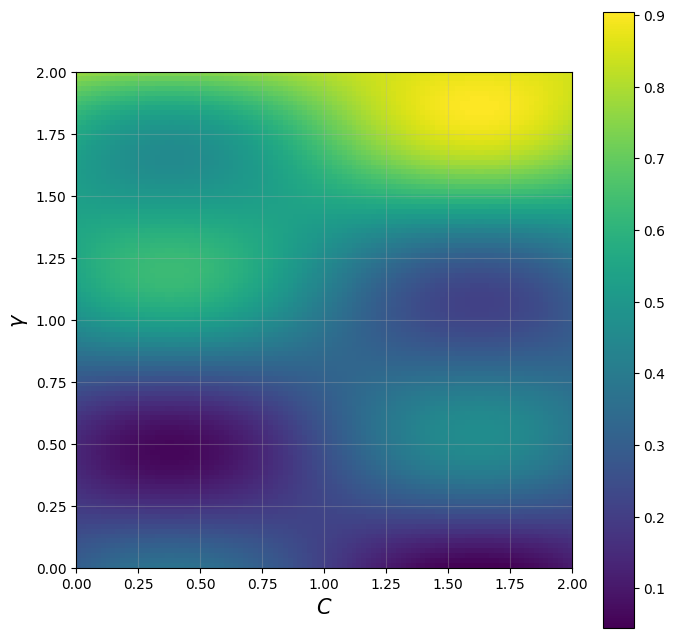

In [78]:
def f(x):
    return (
            torch.sin(5 * x[..., 0] / 2 - 2.5) * torch.cos(2.5 - 5 * x[..., 1])
            + (5 * x[..., 1] / 2 + 0.5) ** 2 / 10
    ) / 5 + 0.2


lb = 0
ub = 2
xs = torch.linspace(lb, ub, 101)
x1, x2 = torch.meshgrid(xs, xs, indexing="ij")
xs = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = f(xs)

plt.figure(figsize=(8, 8))

plt.imshow(ys.reshape(101, 101).T, origin="lower", extent=[lb, ub, lb, ub])
plt.xlabel("$C$", fontsize=15)
plt.ylabel("$\gamma$", fontsize=15)
plt.colorbar()
plt.grid(alpha=0.3)

plt.show()

In [79]:
torch.manual_seed(21)
train_x = torch.rand(size=(100, 2)) * 2
train_y = f(train_x)

In [91]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # 4. 使用常量均值函数和 Matérn 5/2 内核实现 GP 模型，并将输出比例实现为 gpytorch.kernels.ScaleKernel 对象。
        # 5. 初始化内核对象时不要指定ard_num_dims参数或将该参数设置为None。这将创建一个没有 ARD 的 GP 模型。
        # 7. 重新定义GP模型类，这次设置ard_num_dims = 2。用梯度下降重新训练GP模型，并验证两个长度尺度有显着不同的值
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=2)  # None or 2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [92]:
# declare the GP
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.likelihood.noise = noise

# train the hyperparameter (the constant)
# 6. 使用梯度下降训练GP模型的超参数，并检查训练后的长度尺度。
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()
    losses.append(loss.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

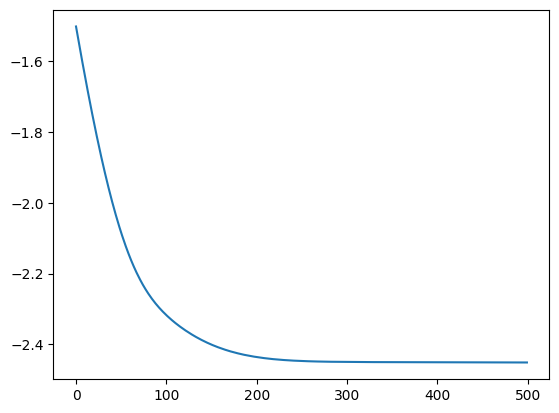

In [93]:
plt.plot(losses)

In [94]:
model.covar_module.base_kernel.lengthscale

tensor([[1.7198, 0.8954]], grad_fn=<SoftplusBackward0>)

# 12.1 [Training a Gaussian process on a large data set](https://github.com/KrisNguyen135/bayesian-optimization-in-action/blob/566c18e3aafaa587c42a3a07c67e5d719c5f2062/CH12/01%20-%20Approximate%20Gaussian%20process%20inference.ipynb)

**DEFINITION:** 变分高斯过程挑选出能够很好地代表整个数据集的一小部分数据。它通过尽量减少自身与接受完整数据训练的常规 GP 之间的差异来实现这一点。术语变分是指研究泛函优化的数学子领域。

In [1]:
import torch
import gpytorch

import matplotlib.pyplot as plt

# plt.style.use("bmh")
# plt.rcParams["image.cmap"] = "Blues"

from tqdm.notebook import tqdm

## 12.1.1 Setting up the learning task

重用在第 2 章和第 3 章中看到的一维目标函数，即 Forrester 函数。

In [7]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)


def visualize_gp_belief(model, likelihood, variational=False):
    # Step 1，我们使用 GP 计算平均值和 CI 预测
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

    plt.figure(figsize=(8, 6))

    plt.plot(xs, ys, label="objective", c="r")
    if not variational:
        plt.scatter(train_x.cpu(), train_y.cpu(), marker="x", c="k", label="observations")

    plt.plot(xs, predictive_mean, label="mean")
    plt.fill_between(
        xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
    )

    if variational:
        plt.scatter(
            train_x.cpu(), train_y.cpu(), marker="x", c="k", alpha=0.1, label="observations"
        )

        inducing_points = model.variational_strategy.inducing_points.detach().clone()
        with torch.no_grad():
            inducing_mean = model(inducing_points).mean

        plt.scatter(
            inducing_points.squeeze(-1),
            inducing_mean,
            marker="D",
            c="orange",
            s=100,
            label="inducing pts",
        )

    plt.legend(fontsize=15)
    plt.ylim(-10, 15)
    plt.show()

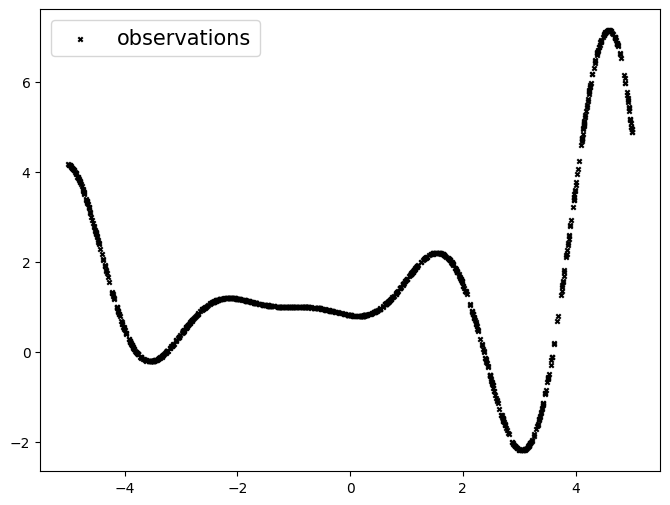

In [8]:
xs = torch.linspace(-7.5, 7.5, 151).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(0)
train_x = torch.rand(size=(1000, 1)) * 10 - 5
train_y = forrester_1d(train_x)

plt.figure(figsize=(8, 6))
plt.scatter(train_x, train_y, c="k", marker="x", s=10, label="observations")
plt.legend(fontsize=15)
plt.show()

## 12.1.2 Training a regular GP

In [4]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_x = train_x.to(device)
train_y = train_y.to(device)

# declare the GP
lengthscale = 1
outputscale = 5
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)  # 似然
model = GPModel(train_x, train_y, likelihood).to(device)

# fix the hyperparameters
model.covar_module.base_kernel.lengthscale = lengthscale
model.covar_module.outputscale = outputscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [11]:
# train the hyperparameter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)  # marginal log likelihood

model.train()
likelihood.train()

losses = []
lengthscales = []
outputscales = []
for i in tqdm(range(150)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    lengthscales.append(model.covar_module.base_kernel.lengthscale.item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/150 [00:00<?, ?it/s]

D:\Anaconda\envs\pytorch\lib\site-packages\linear_operator\utils\linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.8523242473602295 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
D:\Anaconda\envs\pytorch\lib\site-packages\linear_operator\utils\linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.5060362815856934 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
D:\Anaconda\envs\pytorch\lib\site-packages\linear_operator\utils\linear_cg.py:338: NumericalWarning:

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

## 12.1.3 Problems with training a regular Gaussian process

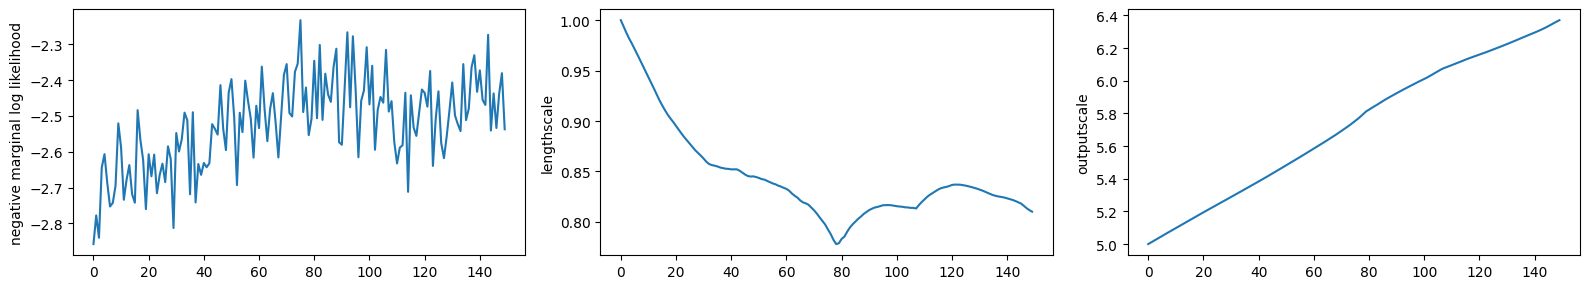

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(lengthscales)
ax[1].set_ylabel("lengthscale")

ax[2].plot(outputscales)
ax[2].set_ylabel("outputscale")

plt.tight_layout()
plt.show()

我们的损失在这里不稳定地上下跳跃，这表明梯度下降并不能很好地最小化损失。事实上，随着我们进行更多的迭代，我们的损失实际上会增加，这意味着我们已经达到了次优模型！这种现象是可以理解的：如果我们错误地计算了模型的损失，那么通过使用错误计算的项来指导梯度下降的学习，我们可能会获得次优的解决方案。


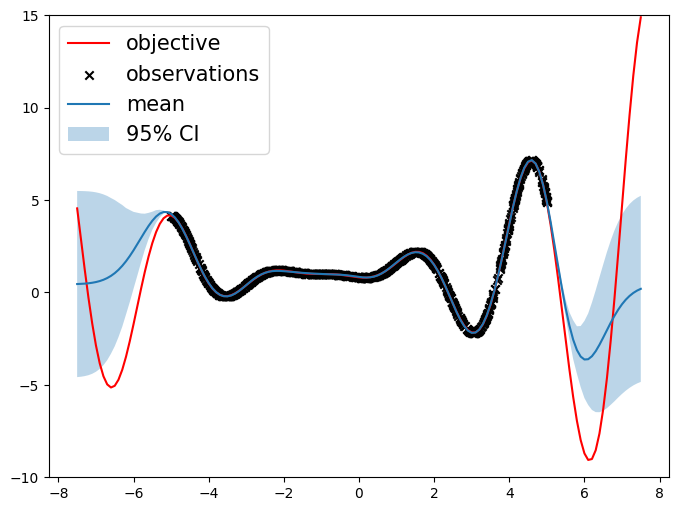

In [20]:
visualize_gp_belief(model, likelihood)

GP 做出的预测中，预测与训练数据匹配良好，但训练需要比较长的时间。

并且其中存在着一些问题：随着训练数据大小的增加，计算梯度下降中使用的损失函数（训练数据的边际对数似然）变得越来越困难。GPyTorch 在训练期间打印出的警告消息表明了这一点。这些消息告诉我们，我们在计算损失时遇到了数值不稳定的情况。数值不稳定使我们无法正确计算损失，从而有效地最小化损失。这可以通过梯度下降 500 次迭代中损失的变化来说明。

总体而言，在大型数据集上训练常规 GP 并不是一个好方法。训练不仅与训练数据的大小呈三次方缩放，而且要优化的损失值的计算也不稳定。

接下来学习变分高斯过程 (Variational GP; VGP)

# 12.2 Automatically choosing representative points from a large dataset

从大数据集中自动选择代表点

VGP 背后的想法是选择一组代表整个数据集的点，并在这个较小的子集上训练 GP。我们已经学会了在小数据集上很好地训练 GP。我们希望这个较小的子集能够捕获整个数据集的总体趋势，因此当 GP 在该子集上进行训练时，丢失的信息最少。

这种做法是很自然的。大型数据集通常包含冗余信息，因此如果我们只能从信息最丰富的数据点中学习，我们可以避免处理这些冗余。GP 的工作原理是假设相似的数据点产生相似的标签。当大型数据集包含许多相似的数据点时，GP 只需关注其中一个数据点即可了解其趋势。例如，即使可以获得每分钟的天气数据，天气预报模型也可以仅从每小时的测量结果中有效地学习。在本节中，我们将学习如何自动执行此操作，确保与从大集合中学习相比，从小子集中学习会导致最小的信息丢失，以及如何使用 GPyTorch 实现此模型。

## 12.2.1 Minimizing the difference between two GPs

如何才能最好地选择这个较小的子集，以便最终的 GP 模型能够从原始数据集中获得最多的信息。该过程相当于找到诱导点的子集，当在该子集上训练 GP 时，将诱导出与在整个数据集上训练的后验 GP 尽可能接近的后验 GP。

深入研究一些数学细节，在训练 VGP 时，我们的目标是最小化以诱导点为条件的后验 GP 与以整个数据集为条件的后验 GP 之间的差异。这需要一种方法来测量两个分布（两个 GP）之间的差异，为此选择的度量是 Kullback-Leibler 散度或 KL 散度。

因此，如果我们可以轻松计算在诱导点上训练的后验 GP 和在整个数据集上训练的后验 GP 之间的 KL 散度，我们应该选择使 KL 散度为零的诱导点。不幸的是，与计算边际对数似然在计算上不稳定类似，计算 KL 散度也不容易。然而，由于其数学特性，我们可以将 KL 散度重写为两个量之间的差：
$$\begin{aligned}
    \text{KL divergence = Marginal log likelihood - ELBO}
\end{aligned}$$
尽管边际对数似然和 KL 散度这两项很难计算，但 ELBO 具有简单的形式并且可以轻松计算。因此，我们不是最小化 KL 散度以使在诱导点上训练的后验 GP 尽可能接近在完整数据集上训练的后验 GP，而是可以最大化 ELBO 作为间接最大化边际对数似然的方法。

总而言之，为了找到一组诱导点，为我们提供一个后验 GP，该后验 GP 与我们能够在大型数据集上训练时获得的 GP 最相似，我们的目标是最小化两个 GP 之间的 KL 散度。然而，这种 KL 散度很难计算，因此我们选择优化 KL 散度的代理，即模型的 ELBO，它更容易计算。正如我们在下一小节中看到的，GPyTorch 提供了一个方便的损失函数来为我们计算这个 ELBO 项。在讨论实现之前，我们还需要讨论一件事：在最大化 ELBO 项时如何考虑大型训练集中的所有数据点。

## 12.2.2 Training the model in small batches

当通过优化 ELBO 项来训练 VGP 时，我们可以通过使用更适合大型数据集的修改版本的梯度下降来避免这种数值不稳定问题。

当我们在少量点上计算模型的损失时，计算可以以稳定且高效的方式完成。此外，通过重复这个近似，我们可以很好地近似真实的损失。最后，我们对这个近似损失运行梯度下降，这希望也能最小化所有数据点的真实损失。

**NOTE:** 并非所有损失函数都可以通过数据子集的损失来近似。换句话说，并非所有损失函数都可以使用小批量梯度下降来最小化。 GP 的负边际对数似然就是一个例子；否则，我们可以在此函数上运行小批量梯度下降。幸运的是，小批量梯度下降适用于 VGP 的 ELBO。

## 12.2.3 Implementing the approximate model

编写一个 VGP 模型类，它与我们使用过的 GP 模型类类似，并使用小批量梯度下降最小化其 ELBO。

除了均值和协方差模块之外，VGP 还需要另外两个组件：
- 变分分布 - 定义 VGP 诱导点上的分布。正如我们在上一节中了解到的，该分布将被优化，以便 VGP 类似于在完整数据集上训练的 GP。
- 变分策略 - 定义如何从诱导点生成预测。在 2.2 节中，我们看到多元正态分布可以根据观察进行更新。这种变分策略有助于对变分分布进行相同的更新。

考虑到这些组件，我们现在实现 VGP 模型类，我们将其命名为 ApproximateGPModel。我们不再在 __init__() 方法中接受训练数据和似然函数。相反，我们采用一组归纳点来表示整个数据集。 __init__() 方法的其余部分包括声明将用于学习哪一组诱导点最好的学习管道：
- variational_distribution 变量是 CholeskyVariationalDistribution 类的实例，它在初始化期间接收诱导点的数量。变分分布是VGP的核心。
- variational_strategy 变量是 VariationalStrategy 类的实例。它接受诱导点集以及变分分布。我们设置 learn_inducing_locations = True，以便我们可以在训练期间学习这些诱导点的最佳位置。如果该变量设置为 False，则传递给 __init__() 的点（存储在 inducing 中）将用作诱导点：



In [4]:
class ApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # 定义 VI 分布
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        # 定义 VI 策略
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)
        # 核参数
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [9]:
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

# declare the GP
lengthscale = 1
outputscale = 5
noise = 1e-4

model = ApproximateGPModel(train_x[:50, :])  # 使用50个诱导点
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# fix the hyperparameters
model.covar_module.base_kernel.lengthscale = lengthscale
model.covar_module.outputscale = outputscale
likelihood.noise = noise

**NOTE:** 一般规则是诱导点不要超过 1,000 个。正如我们稍后讨论的，50 个点足以让我们以高保真度逼近上一小节中经过训练的 GP。

In [10]:
optimizer = torch.optim.Adam(
    [{"params": model.parameters()}, {"params": likelihood.parameters()}], lr=0.01
)
"""
要优化的参数 以前，我们只需要将 model.parameters() 传递给 Adam。
在这里，似然度不与 VGP 模型耦合——常规 GP 使用似然度进行初始化，而 VGP 则不然。
因此，在这种情况下，有必要将likelihood.parameters()传递给Adam。
"""
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

model.train()
likelihood.train()

losses = []
lengthscales = []
outputscales = []
for i in tqdm(range(15)):
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()

        output = model(x_batch)
        loss = -mll(output, y_batch)

        loss.backward()

        losses.append(loss.item())
        lengthscales.append(model.covar_module.base_kernel.lengthscale.item())
        outputscales.append(model.covar_module.outputscale.item())

        optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/15 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

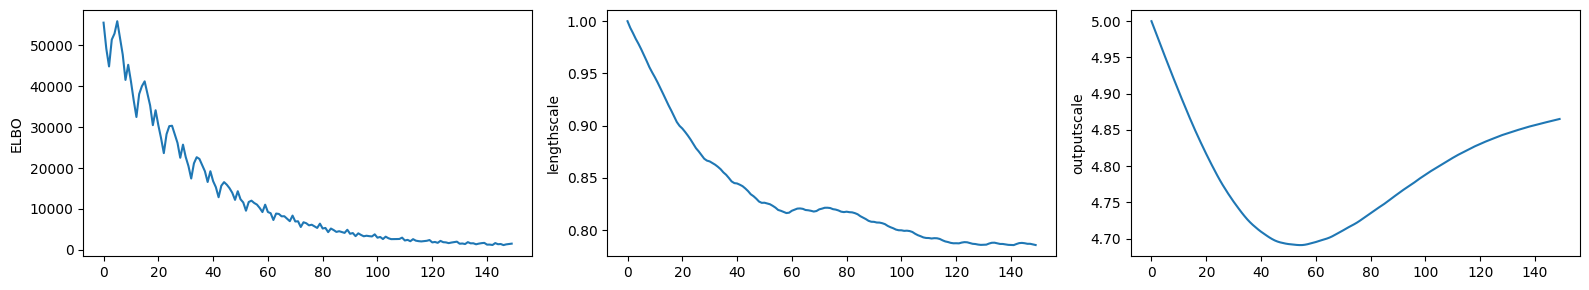

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].plot(losses)
ax[0].set_ylabel("ELBO")

ax[1].plot(lengthscales)
ax[1].set_ylabel("lengthscale")

ax[2].plot(outputscales)
ax[2].set_ylabel("outputscale")

plt.tight_layout()
plt.show()

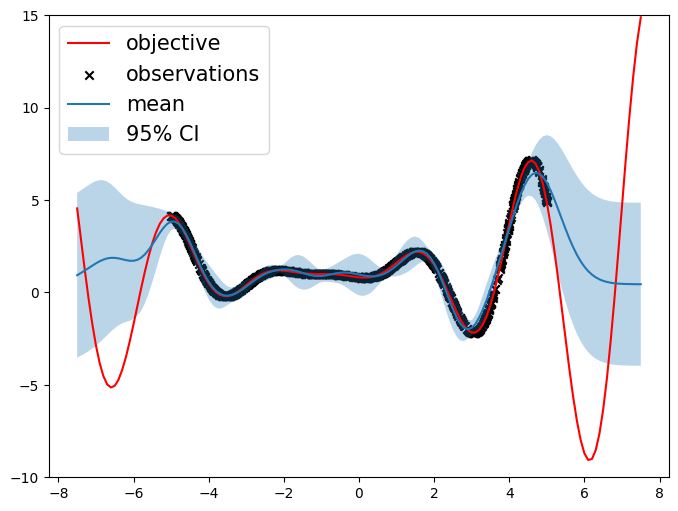

In [12]:
visualize_gp_belief(model, likelihood)

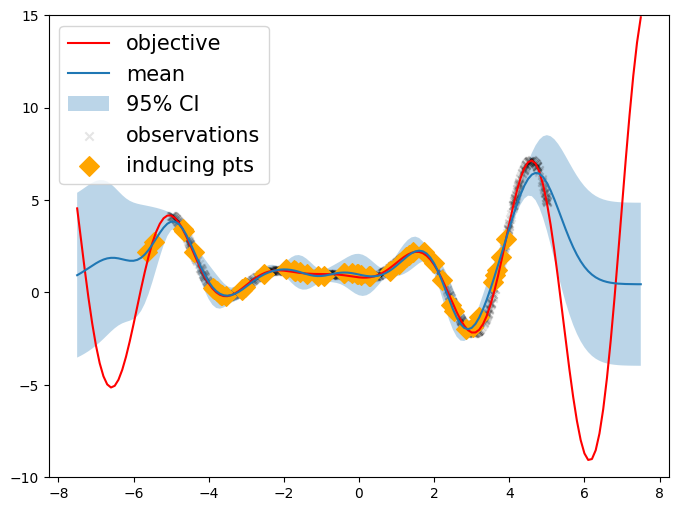

In [13]:
visualize_gp_belief(model, likelihood, variational=True)

# 12.3 Optimizing better by accounting for the geometry of the loss surface

通过考虑损失表面的几何形状更好地优化

在本节中，我们将学习称为自然梯度下降的算法，这是梯度下降的另一种版本，在计算下降步骤时更仔细地推理损失函数的几何形状。正如我们很快看到的，这种仔细的推理使我们能够快速降低损失函数，最终以更少的迭代次数实现更有效的优化（即更快的收敛）。

为了理解自然梯度下降的动机以及为什么它比我们现有的更好，我们首先区分 VGP 的两种类型的参数：
- 第一类是 GP 的常规参数，例如平均常数以及协方差函数的长度和输出尺度。这些参数采用欧几里德空间中存在的常规数值。
- 第二种类型由只有 VGP 具有的变分参数组成。这些与诱导点和促进变分分布近似所需的各种组件有关。换句话说，这些参数与概率分布相关，并且具有无法在欧几里德空间内很好地表示的值。

尽管我们在上一节中使用的小批量梯度下降效果足够好，但该算法假设所有参数都存在于欧几里得空间中。例如，从算法的角度来看，长度尺度为1和长度尺度为2之间的差值与诱导点平均值为1和平均值为2之间的差值相同。但是，这并不相同。从长度尺度 1 到长度尺度 2 对 VGP 模型的影响与从诱导点平均值 1 到平均值 2 的影响非常不同。

这种行为差异的存在是因为损失函数相对于 VGP 常规参数的几何形状与相对于变分参数的损失函数的几何形状根本不同。如果小批量梯度下降在计算损失的下降方向时可以考虑这种几何差异，那么该算法将更有效地最小化该损失。这就是自然梯度下降的用武之地。

**DEFINITION:** 定义自然梯度下降使用有关变分参数的损失函数的几何信息来计算这些参数的更好的下降方向。

**NOTE:** 自然梯度下降算法仅优化 VGP 的变分参数。常规参数，例如长度和输出尺度，仍然可以通过常规小批量梯度下降算法进行优化。

